In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import auc
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
import timeit

# Clean Data

## July Data

In [ ]:
values = ['tdmp_bytes_created','tdmp_bytes_total','tdmp_packets_created','tdmp_packets_total']
services = ['http','postgresql','ssh']
files = ['2021-04-01_2021-05-01','2021-05-01_2021-06-01','2021-06-01_2021-07-01','2021-07-01_2021-08-01']

In [ ]:
for value in values:
    for service in services:
        path = 'old_dataset/' + value + '/' + service + '/'
        for file in files:
            with open(path + file + '.csv', "r") as input_file:
                rows = input_file.readlines()

            with open(path + file + '_clean.csv', "w") as output_file:
                for row in rows:
                    if row[0] != '#':
                        output_file.write(row) 
            try:
                df = pd.read_csv(path + file + '_clean.csv',header=0)
                df = df.drop(['Unnamed: 0', 'result','table','_start','_stop','_field','_measurement','service','host'], axis=1)
                df.to_csv(path + file + '_clean.csv',index=False)
            except:
                continue
            

## December Data

In [2]:
values = ['tdmp_bytes_created','tdmp_bytes_total','tdmp_packets_created','tdmp_packets_total']

In [5]:
for value in values:
    path = 'new_dataset/' + value
    with open(path + '.csv', "r") as input_file:
        rows = input_file.readlines()

    with open(path + '_clean.csv', "w") as output_file:
        for row in rows:
            if row[0] != '#':
                output_file.write(row) 
    try:
        df = pd.read_csv(path + '_clean.csv',header=0)
        df = df.drop(['Unnamed: 0','result','_start','_stop','_field','_measurement','service','host'], axis=1)
        df.to_csv(path + '_clean.csv',index=False)
    except:
        continue
            

# Plot Data

## July Data

In [ ]:
values = ['tdmp_bytes_created','tdmp_bytes_total','tdmp_packets_created','tdmp_packets_total']
services = ['http','postgresql','ssh']
files = ['2021-04-01_2021-05-01_clean','2021-05-01_2021-06-01_clean','2021-06-01_2021-07-01_clean','2021-07-01_2021-08-01_clean']

for value in values:
    for service in services:
        title = value + ' ' + service        
        path = 'old_dataset/' + value + '/' + service + '/'
        df = pd.DataFrame()
        for file in files:            
            f = pd.read_csv(path + file + '.csv',header=0).sort_values(by='_time',ascending=True)                
            df = pd.concat([df,f],axis=0,ignore_index=True)                
            fig = plt.figure(figsize=(30, 15))
            plt.xticks(rotation=45)
            plt.title(file)
            plt.plot(df["_time"], df["_value"])
            plt.show()
            #fig.savefig('old_dataset/' + value + '/' + service + '/plots/' + file + '.png', dpi=fig.dpi)       


## December Data

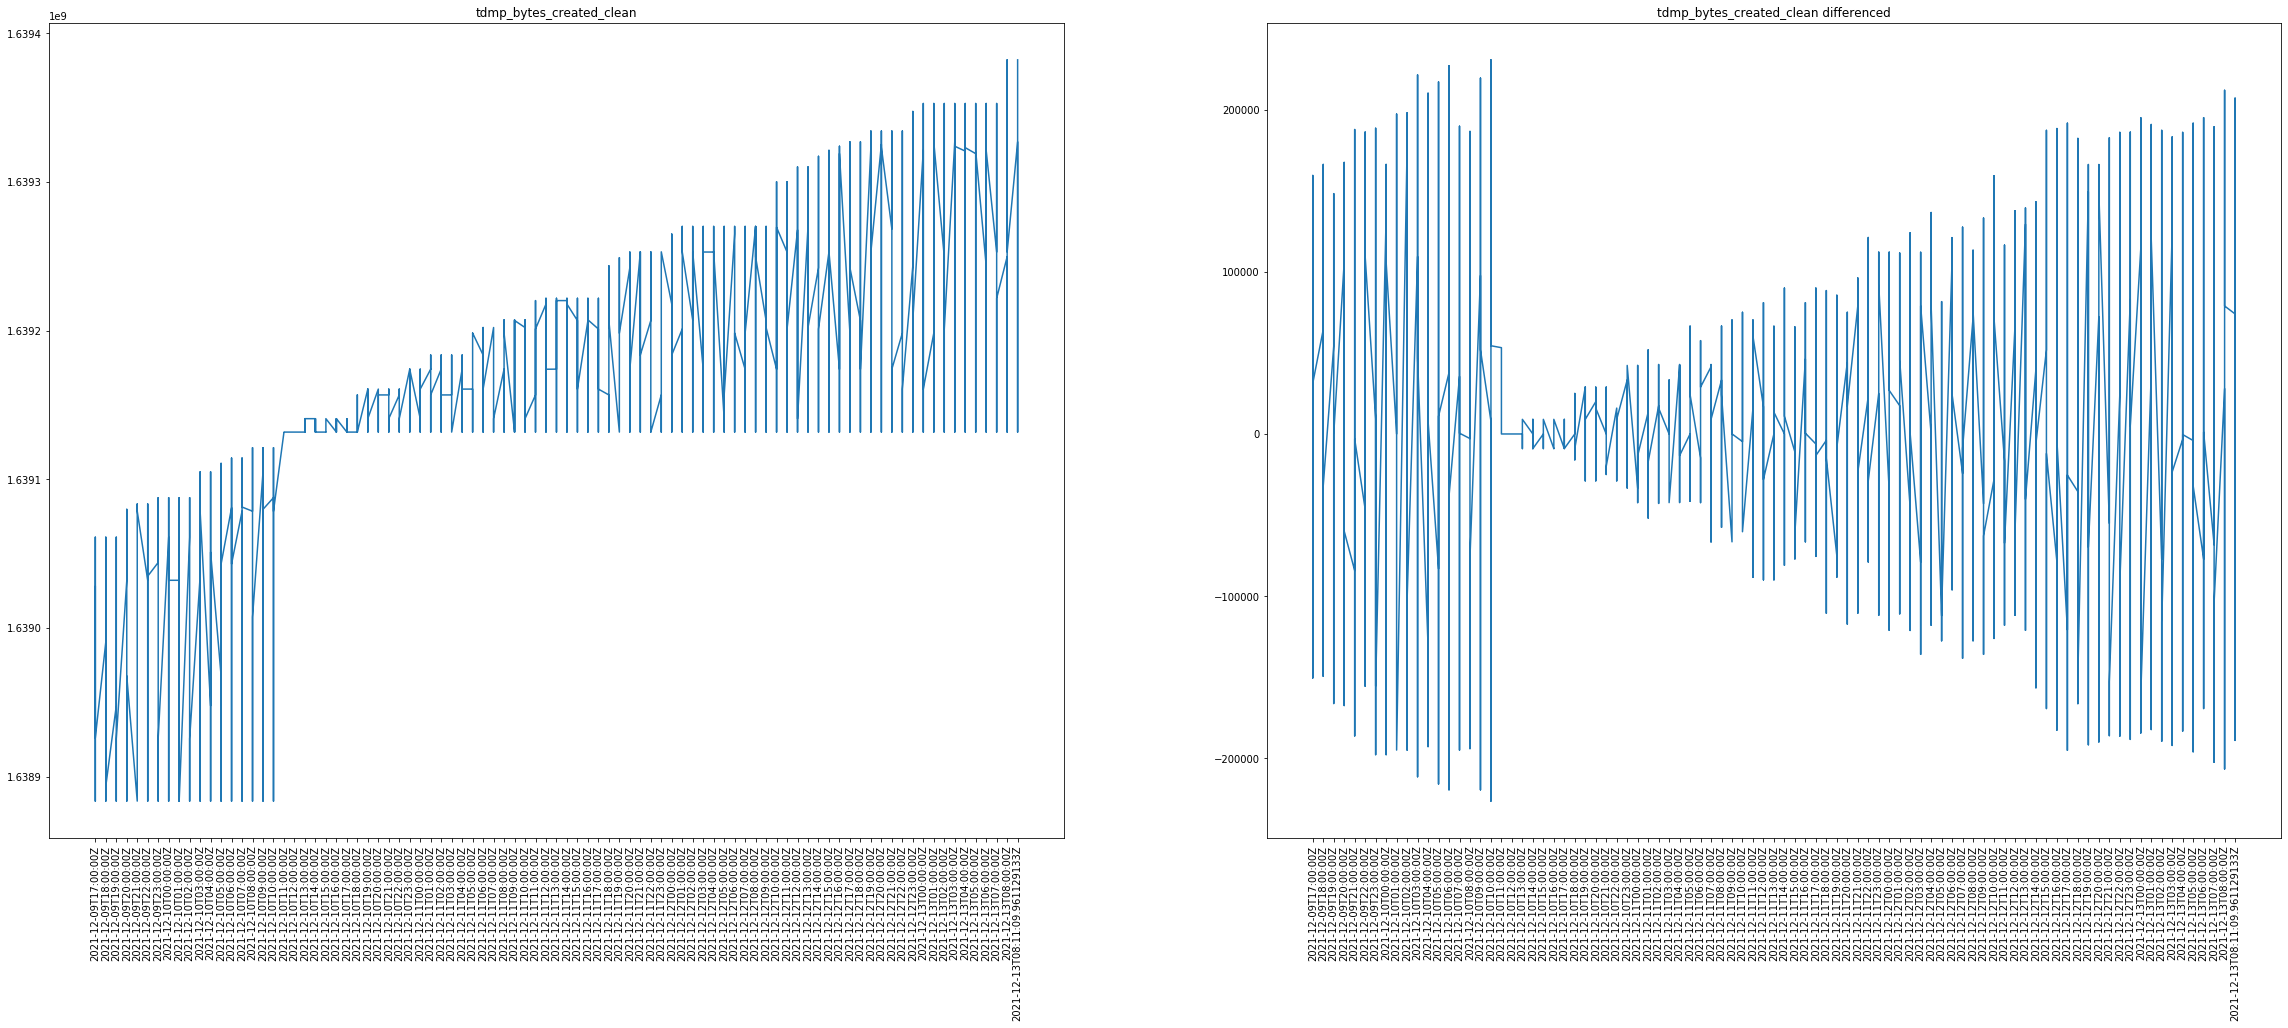

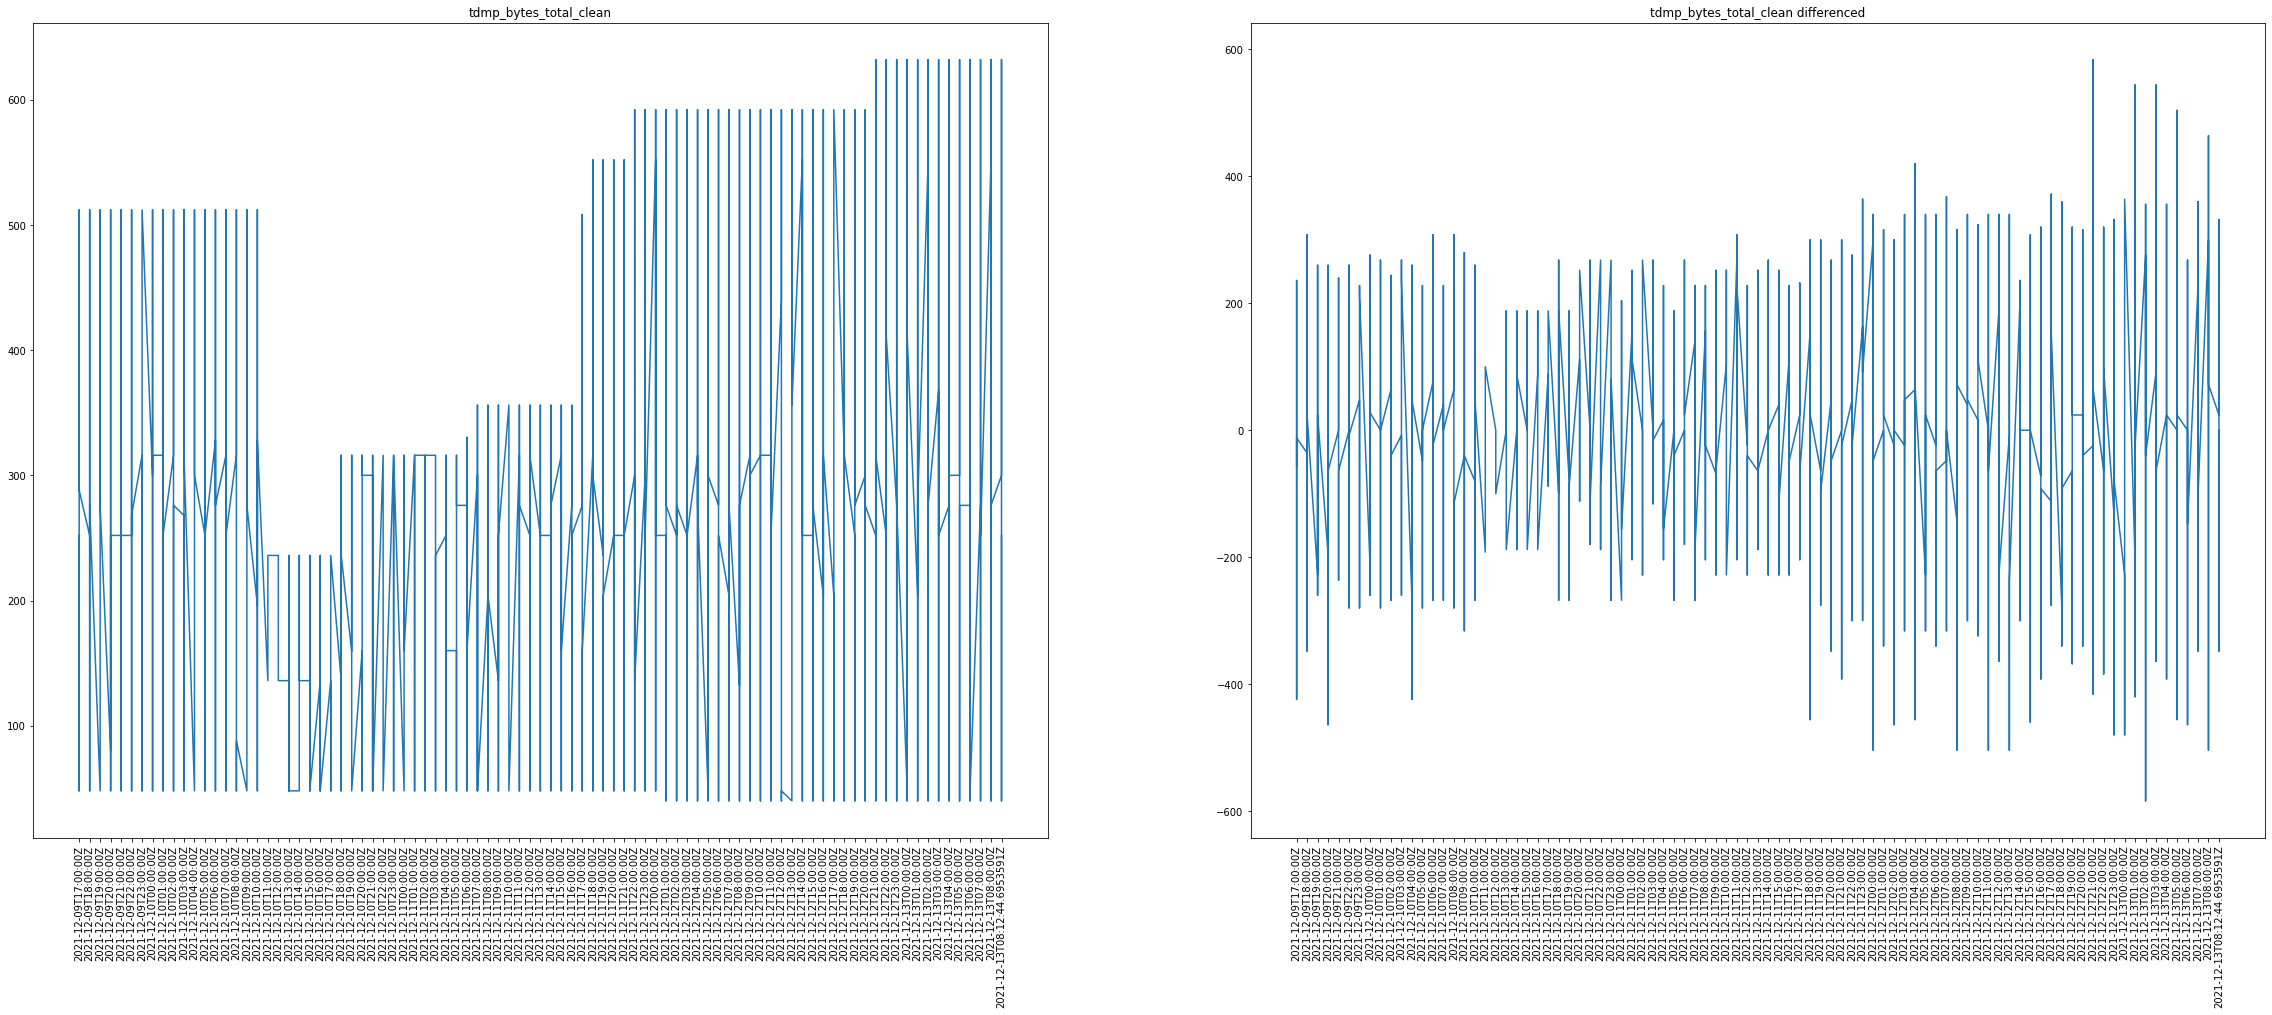

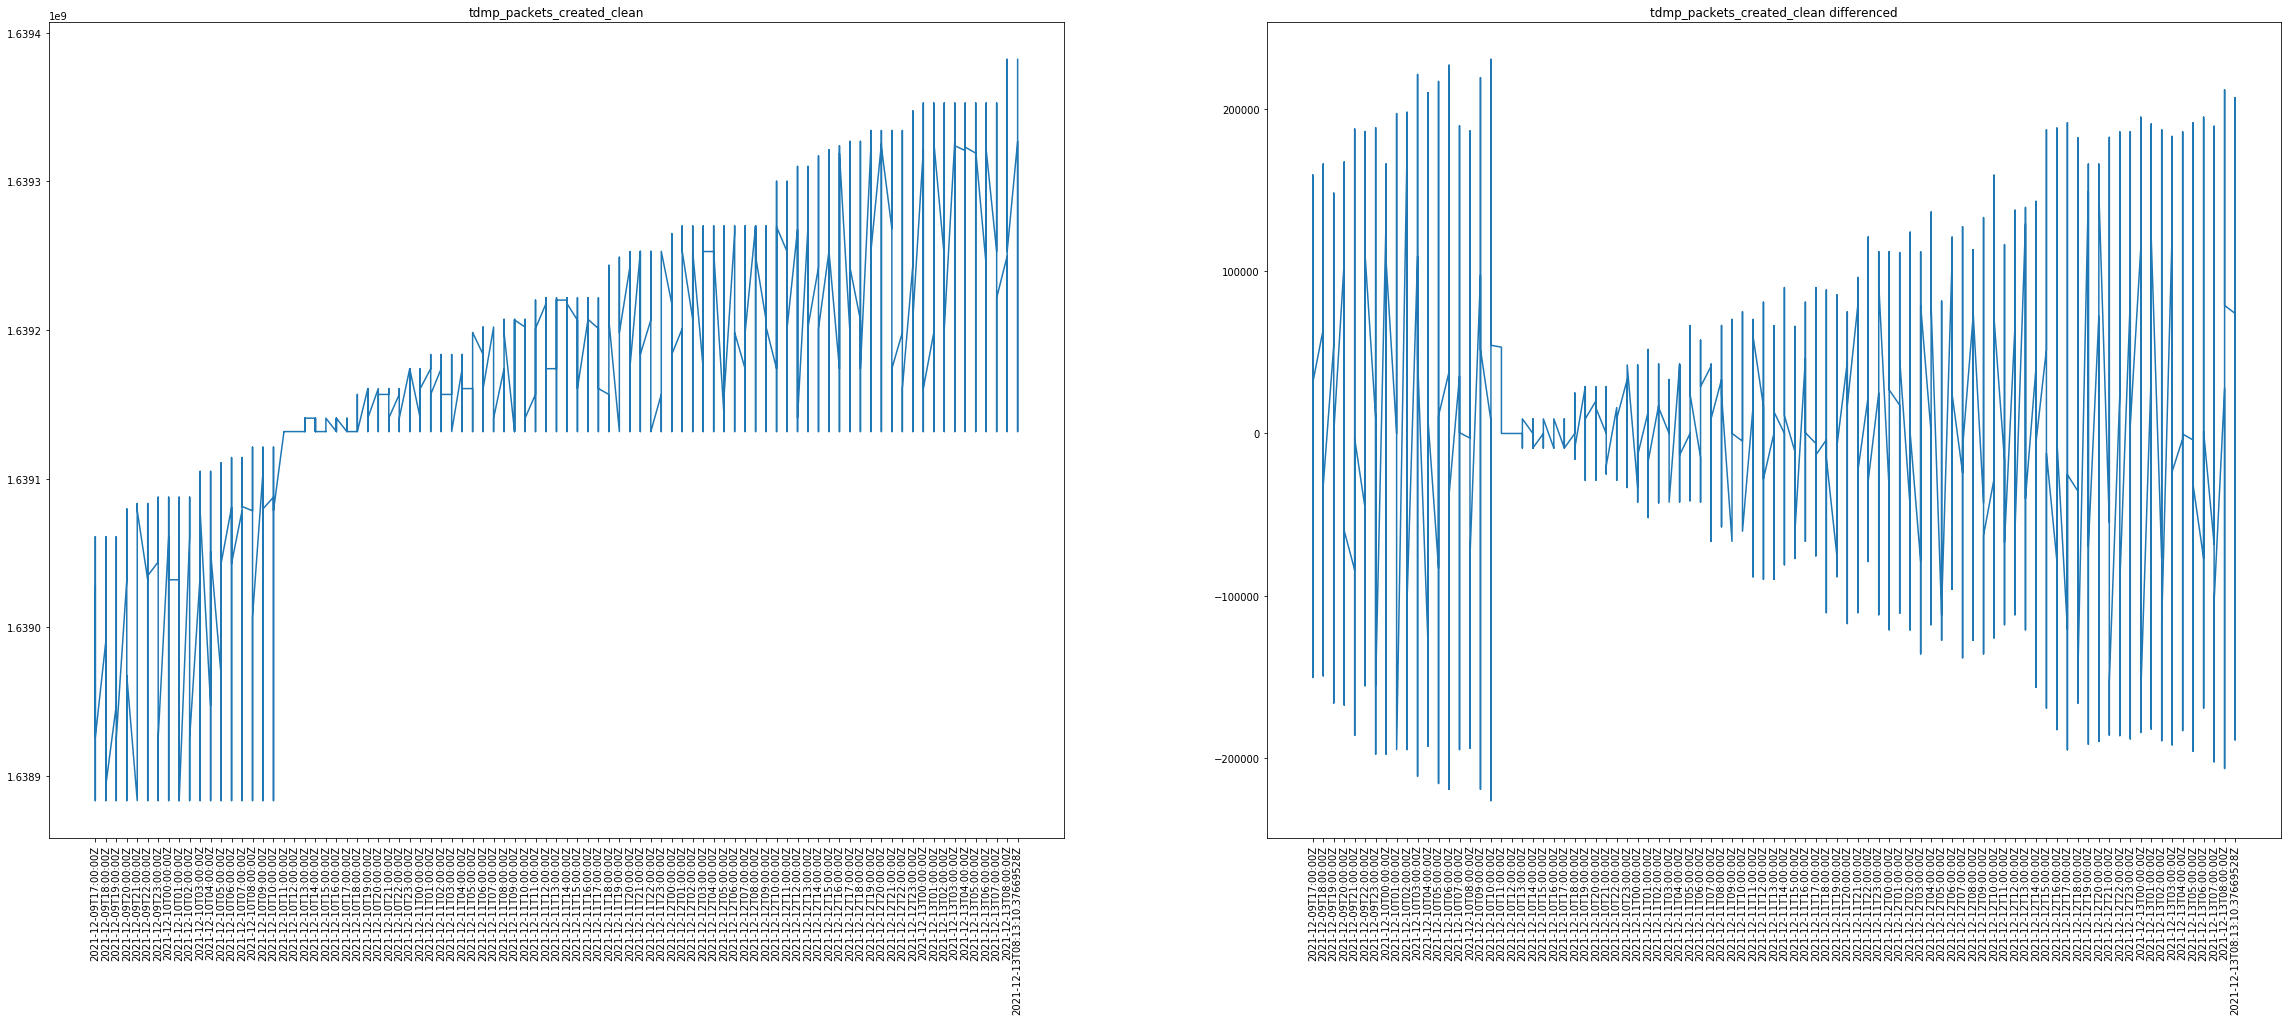

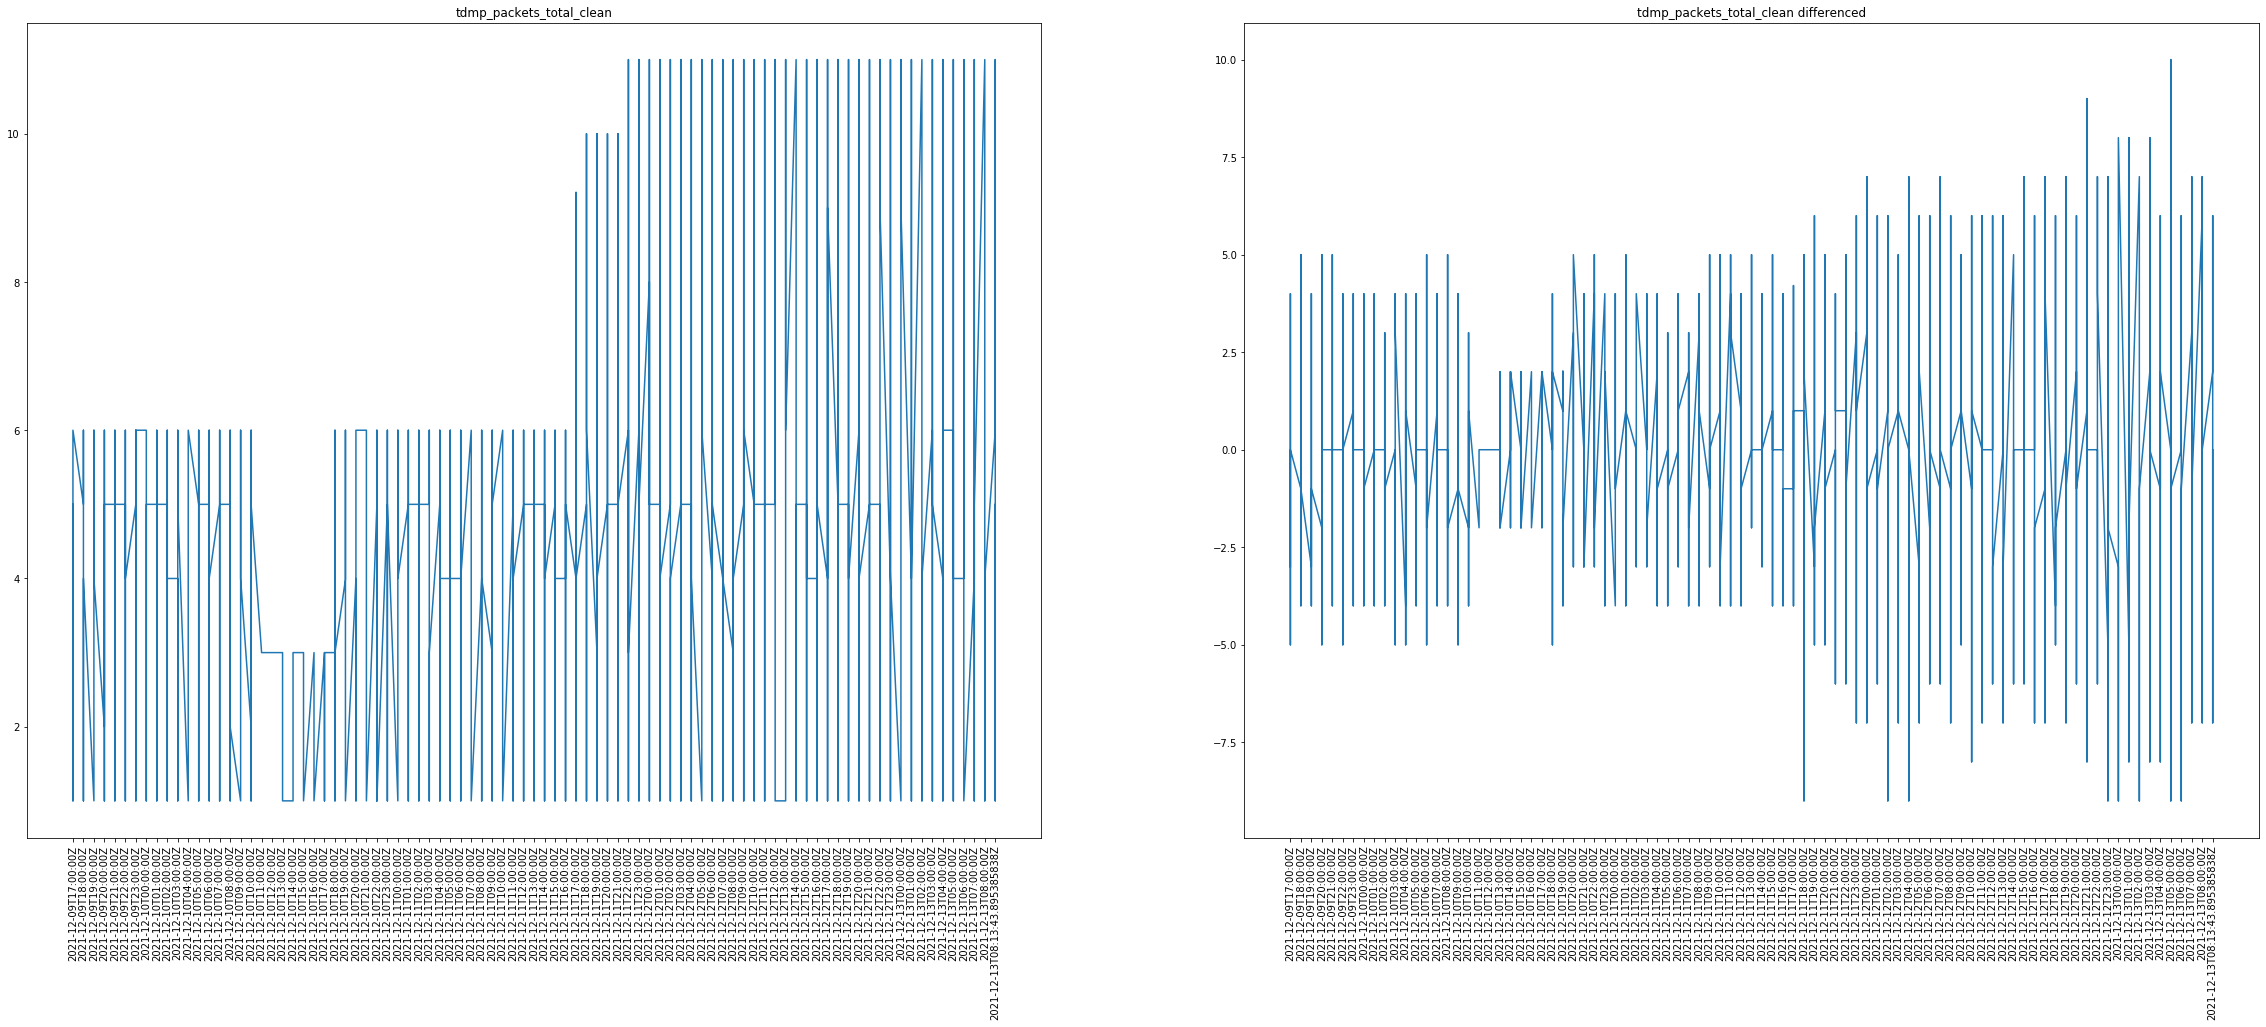

In [113]:
values = ['tdmp_bytes_created_clean','tdmp_bytes_total_clean','tdmp_packets_created_clean','tdmp_packets_total_clean']

for value in values:
    path = 'new_dataset/' + value
    df = pd.DataFrame()          
    f = pd.read_csv(path + '.csv',header=0).sort_values(by='_time',ascending=True)                
    df = pd.concat([df,f],axis=0,ignore_index=True)                
    
    fig = plt.figure(figsize=(40, 15))        
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.set_title(value)
    ax2.set_title(value + " differenced")
    ax1.plot(df["_time"], df["_value"])
    ax1.tick_params(axis='x', rotation=90)
    ax2.plot(df["_time"], df["_value"].diff())
    ax2.tick_params(axis='x', rotation=90)
    plt.show()
    fig.savefig('new_dataset/plots/' + value + '.png', dpi=fig.dpi)
    

# Z-Score New Data

In [114]:
def isAnomaly(value,mean,std):
    if float(std) == 0:
        return 0
    else:
        zscore = (value - mean) / std
        if zscore > 3:
            return 1
        else:
            return 0

In [115]:
values = ['tdmp_bytes_created_clean','tdmp_bytes_total_clean','tdmp_packets_created_clean','tdmp_packets_total_clean']

for value in values:
    path = 'new_dataset/' + value
    df = pd.DataFrame()          
    f = pd.read_csv(path + '.csv',header=0).sort_values(by='_time',ascending=True)                
    df = pd.concat([df,f],axis=0,ignore_index=True) 
    df['_value_diff'] = df['_value'].diff()
    stats = pd.DataFrame()
    stats['avg'] = df.groupby('table')['_value'].mean()
    stats['std'] = df.groupby('table')['_value'].std()
    stats['avg_diff'] = df.groupby('table')['_value_diff'].mean()
    stats['std_diff'] = df.groupby('table')['_value_diff'].std()    
    stats_dict = stats.T.to_dict('list')
    df['anomaly'] = df.apply(lambda row: isAnomaly(row['_value'],stats_dict[row['table']][0],stats_dict[row['table']][1]),axis=1)
    df['anomaly_diff'] = df.apply(lambda row: isAnomaly(row['_value_diff'],stats_dict[row['table']][2],stats_dict[row['table']][3]),axis=1)
    df.to_csv('new_dataset/zscore/' + value + '.csv',index=False)


In [133]:
for value in values:
    path = 'new_dataset/zscore/' + value
    f = pd.read_csv(path + '.csv',header=0)
    print(value)
    print('#anomalies: ' + str(f.loc[f['anomaly']==1].shape[0]), '#normal: ' + str(f.loc[f['anomaly']==0].shape[0]))
    print('#anomalies_diff: ' + str(f.loc[f['anomaly_diff']==1].shape[0]), '#normal_diff: ' + str(f.loc[f['anomaly_diff']==0].shape[0]))
    print()
      

tdmp_bytes_created_clean
#anomalies: 276 #normal: 4696
#anomalies_diff: 1 #normal_diff: 4971

tdmp_bytes_total_clean
#anomalies: 0 #normal: 4972
#anomalies_diff: 14 #normal_diff: 4958

tdmp_packets_created_clean
#anomalies: 428 #normal: 4544
#anomalies_diff: 1 #normal_diff: 4971

tdmp_packets_total_clean
#anomalies: 0 #normal: 4972
#anomalies_diff: 4 #normal_diff: 4968



# Check new entries New Data

In [134]:
import influxdb_client
from influxdb_client.client.write_api import SYNCHRONOUS

In [136]:
bucket = "riot"
org = "polimi"
token = "d2VsY29tZQ=="
url="http://35.152.63.133:8086"

client = influxdb_client.InfluxDBClient(
   url=url,
   token=token,
   org=org
)

query_api = client.query_api()

In [189]:
tags = ['dst','dstp','service','src','srcp','url']

for tag in tags:
    path = 'new_dataset/lists/' + tag
    df = pd.read_csv(path + '.csv',header=0)
    l = df['value'].tolist()
    #eseguito giornalieralmente
    q = 'import "influxdata/influxdb/schema"\
        schema.tagValues(\
        bucket: "riot",\
        tag: "' + tag + '",\
        start: -1d)'
    result = query_api.query(org=org, query=q)
    results = []
    for table in result:
        for record in table.records:
            results.append((record.get_value()))
    diffs = list(set(results) - set(l))
    if len(diffs) != 0:
        print('*** New ' + tag + ' ***')
        for diff in diffs:
            print(diff)
            new_row = {'value': diff}
            df = df.append(new_row, ignore_index=True)
    df.to_csv('new_dataset/lists/' + tag + '.csv',index=False)

*** New dst ***
2880008888.ezo
92.63.197.108
*** New dstp ***
29308
2161
7185
12117
11846
42290
41812
12118
54443
16234
29306
2156
11865
53299
24320
56843
11848
2173
54744
11847
29311
7184
16197
41811
16258
8777
12110
34342
41814
29305
2159
12113
16184
29295
27689
7219
51992
16239
2155
34337
12111
2149
34349
29314
2153
2183
7221
41984
34338
54185
7218
2151
50595
37556
7176
7199
29307
29313
41815
7200
55443
34343
16330
57253
12116
34344
8762
8778
2168
15899
7177
34336
29302
63794
7178
41809
16200
8763
54017
15842
24318
2160
29296
29310
29319
45855
2167
41800
29303
29297
15890
2152
56855
50682
20015
7191
11872
21786
29312
41813
12106
7212
2163
7222
51901
2154
41810
41816
2175
60806
60398
61920
38939
7210
12104
7211
*** New src ***
2880008888.ezo
*** New srcp ***
29308
2161
7185
12117
11846
42290
41812
12118
54443
16234
29306
2156
11865
53299
24320
56843
11848
2173
54744
11847
29311
7184
16197
41811
16258
8777
12110
34342
41814
29305
2159
12113
16184
16239
7219
51992
2155
12111
34349
2931

# Process Data

In [ ]:
# Define metrics to use

# più grande è, meglio è
def em(t, t_max, volume_support, s_unif, s_X, n_generated):
    EM_t = np.zeros(t.shape[0])
    n_samples = s_X.shape[0]
    s_X_unique = np.unique(s_X)
    EM_t[0] = 1.
    for u in s_X_unique:
        # if (s_unif >= u).sum() > n_generated / 1000:
        EM_t = np.maximum(EM_t, 1. / n_samples * (s_X > u).sum() -
                          t * (s_unif > u).sum() / n_generated
                          * volume_support)
    amax = np.argmax(EM_t <= t_max) + 1
    if amax == 1:
        print ('\n failed to achieve t_max \n')
        amax = -1
    AUC = auc(t[:amax], EM_t[:amax])
    return AUC, EM_t, amax


# più piccolo è, meglio è
def mv(axis_alpha, volume_support, s_unif, s_X, n_generated):
    n_samples = s_X.shape[0]
    s_X_argsort = s_X.argsort()
    mass = 0
    cpt = 0
    u = s_X[s_X_argsort[-1]]
    mv = np.zeros(axis_alpha.shape[0])
    for i in range(axis_alpha.shape[0]):
        # pdb.set_trace()
        while mass < axis_alpha[i]:
            cpt += 1
            u = s_X[s_X_argsort[-cpt]]
            mass = 1. / n_samples * cpt  # sum(s_X > u)
        mv[i] = float((s_unif >= u).sum()) / n_generated * volume_support
    return auc(axis_alpha, mv), mv


In [ ]:
n_generated = 100000
alpha_min = 0.9
alpha_max = 0.999
t_max = 0.9
ocsvm_max_train = 10000
np.random.seed(1)

In [ ]:
def split_df(df):    
    df['_time'] = pd.to_datetime(df['_time']).astype(np.int64) / int(1e6)
    encoder = OneHotEncoder(handle_unknown='ignore')
    ohencDf = df.copy()
    encoding = pd.DataFrame(encoder.fit_transform(ohencDf[["dst","dstp","proto","src","srcp","url"]]).toarray())
    ohencDf = ohencDf.drop(["dst","dstp","proto","src","srcp","url"],axis=1)
    ohencDf = ohencDf.join(encoding)
    n_train = int(ohencDf.shape[0] * 0.8)
    train = np.array(ohencDf.head(n_train))
    test = (ohencDf.tail(ohencDf.shape[0]-n_train))
    return ohencDf,np.array(train),np.array(test)

In [ ]:
def calculate_parameters(df):
    lim_inf = np.array(df).min(axis=0)
    lim_sup = np.array(df).max(axis=0)
    volume_support = (lim_sup - lim_inf).prod()
    volume_support = volume_support if volume_support > 1 else 1
    t = np.arange(0, 100 / volume_support, 0.01 / volume_support)
    axis_alpha = np.arange(alpha_min, alpha_max, 0.0001)
    unif = np.random.uniform(lim_inf, lim_sup,size=(n_generated, df.shape[1]))
    return t,volume_support,axis_alpha,unif

In [ ]:
def evaluate_model(model,train,test,unif,reshape=False):
    model.fit(train)
    s_X_model = model.decision_function(test)
    s_unif_model = model.decision_function(unif)
    if reshape:
        #model.fit(train[:min(ocsvm_max_train, n_samples_train - 1)])
        s_X_model = s_X_model.reshape(1, -1)[0]
        s_unif_model = s_unif_model.reshape(1, -1)[0]                           
    return s_X_model,s_unif_model

In [ ]:
def calculate_metrics(t,volume_support,s_unif_model,s_X_model,axis_alpha):
    auc_em_model,em_model,amax_model = em(t, t_max,volume_support,s_unif_model,s_X_model,n_generated)
    auc_mv_model,mv_model = mv(axis_alpha,volume_support,s_unif_model, s_X_model,n_generated)
    return auc_em_model,em_model,amax_model,auc_mv_model,mv_model

In [ ]:
def plot(path,title,t,amax,em_iforest,mv_iforest,auc_em_iforest,auc_mv_iforest,em_lof,mv_lof,auc_em_lof,auc_mv_lof,em_ocsvm,mv_ocsvm,auc_em_ocsvm,auc_mv_ocsvm,axis_alpha):
    plt.clf()    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5))
    fig.suptitle(title,fontsize=25,y=1.05)    

    ax1.plot(t[:amax], em_iforest[:amax], lw=1,label='%s (em_score = %0.3e)'% ('iforest', auc_em_iforest))
    ax1.plot(t[:amax], em_lof[:amax], lw=1,label='%s (em-score = %0.3e)'% ('lof', auc_em_lof))
    ax1.plot(t[:amax], em_ocsvm[:amax], lw=1,label='%s (em-score = %0.3e)'% ('ocsvm', auc_em_ocsvm))
    ax1.set_xlabel('t',fontsize=20)
    ax1.set_ylabel('EM(t)',fontsize=20)
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_title('Excess-Mass curve', fontsize=20)
    ax1.legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),fancybox=True)

    ax2.plot(axis_alpha, mv_iforest, lw=1,label='%s (mv-score = %0.3e)'% ('iforest', auc_mv_iforest))
    ax2.plot(axis_alpha, mv_lof, lw=1,label='%s (mv-score = %0.3e)'% ('lof', auc_mv_lof))
    ax2.plot(axis_alpha, mv_ocsvm, lw=1,label='%s (mv-score = %0.3e)'% ('ocsvm', auc_mv_ocsvm))    
    ax2.set_xlabel('alpha', fontsize=20)
    ax2.set_ylabel('MV(alpha)', fontsize=20)
    ax2.set_title('Mass-Volume Curve', fontsize=20)
    ax2.legend(loc="upper center",bbox_to_anchor=(0.5,-0.15),fancybox=True)
    
    fig.subplots_adjust(wspace=0.4)
    #plt.show()
    plt.tight_layout()
    plt.savefig(path + 'EM_MV_plot.png',bbox_inches='tight')

In [ ]:
files = ['2021-04-01_2021-05-01_clean','2021-05-01_2021-06-01_clean','2021-06-01_2021-07-01_clean','2021-07-01_2021-08-01_clean']

for value in values:
    for service in services:
        title = value + ' ' + service
        print(title)
        path = 'dataset/' + value + '/' + service + '/'
        df = pd.DataFrame()
        for file in files:            
            try:
                f = pd.read_csv(path + file + '.csv',header=0).sort_values(by='_time',ascending=True)                
                df = pd.concat([df,f],axis=0,ignore_index=True)                
            except:
                continue        
        df_tot,df_train,df_test = split_df(df)
        t,volume_support,axis_alpha,unif = calculate_parameters(df_tot)
        start = timeit.default_timer()
        s_X_iforest,s_unif_iforest = evaluate_model(IsolationForest(),df_train,df_test,unif)
        s_X_lof,s_unif_lof = evaluate_model(LocalOutlierFactor(n_neighbors=20,novelty=True),df_train,df_test,unif)
        s_X_ocsvm,s_unif_ocsvm = evaluate_model(OneClassSVM(),df_train,df_test,unif,True)
        stop = timeit.default_timer()
        print('Time: ', stop - start)
        auc_em_iforest,em_iforest,amax_iforest,auc_mv_iforest,mv_iforest = calculate_metrics(t,volume_support,s_unif_iforest,s_X_iforest,axis_alpha)
        auc_em_lof,em_lof,amax_lof,auc_mv_lof,mv_lof = calculate_metrics(t,volume_support,s_unif_lof,s_X_lof,axis_alpha)
        auc_em_ocsvm,em_ocsvm,amax_ocsvm,auc_mv_ocsvm,mv_ocsvm = calculate_metrics(t,volume_support,s_unif_ocsvm,s_X_ocsvm,axis_alpha)
        if amax_iforest == -1 or amax_lof == -1 or amax_ocsvm == -1:
            amax = -1
        else:
            amax = max(amax_iforest, amax_lof, amax_ocsvm)
        plot(path,title,t,amax,em_iforest,mv_iforest,auc_em_iforest,auc_mv_iforest,em_lof,mv_lof,auc_em_lof,auc_mv_lof,em_ocsvm,mv_ocsvm,auc_em_ocsvm,auc_mv_ocsvm,axis_alpha)
        